In [211]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

pd.set_option('display.max_columns', 300)

%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import re
import string

import scipy
from textblob import TextBlob

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [212]:
from tqdm import tqdm
tqdm.pandas()

In [213]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [214]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [215]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http",
              "https","char","reuters","wall","street","journal","photo","\n"]

In [216]:
domain_extensions = ['.com/','.org/','.net/','.co.uk/']

def url_subpages(url):
    for extension in domain_extensions:
        try:
            if extension in url:
                re_test = re.search(extension,url)
                start_pos = re_test.start()+len(extension)
                cut = url[start_pos:]

                re_test2 = re.search('/',cut)
                end_pos = re_test2.start()
                cut2 = cut[0:end_pos]

                return cut2
            else:
                pass
        except:
            return "no clear section"


In [217]:
def black_txt(token):
    return  token not in stopwords and token not in list(string.punctuation)  and len(token)>3

def clean_txt(text, string = True):
    clean_text = []
    clean_text2 = []
    text = re.sub("'", "",text)
    text = re.sub("\n", "",text)
    text=re.sub("(\\d|\\W)+"," ",text)    
    clean_text = [ lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    
    if string == True:
        return " ".join(clean_text2)
    else:
        return clean_text2

# Read and Clean

In [218]:
#load in data
data = pd.read_csv('initial_data.csv', index_col = 0)
data.reset_index(drop=True, inplace=True)
data = data.drop_duplicates('url', keep = 'first')
data.drop(['urlToImage'],axis=1,inplace=True)

In [219]:
conditions = [
    (data['content'].isna())
]

choices = [
    (data['description'])
]

data['content'] = np.select(conditions, choices, data['content'])

In [220]:
#drop where description is isna()
to_drop = data[data['description'].isna()].index
data.drop(to_drop, inplace=True)

#drop where title is isna()
to_drop = data[data['title'].isna()].index
data.drop(to_drop, inplace=True)

#drop where target is isna()
to_drop = data[data['target'].isna()].index
data.drop(to_drop, inplace=True)

#drop where publishedAt is isna()
to_drop = data[data['publishedAt'].isna()].index
data.drop(to_drop, inplace=True)

#drop where month is isna()
to_drop = data[data['month'].isna()].index
data.drop(to_drop, inplace=True)

#drop where content is isna()
to_drop = data[data['content'].isna()].index
data.drop(to_drop, inplace=True)

#drop where url is isna()
to_drop = data[data['url'].isna()].index
data.drop(to_drop, inplace=True)

In [221]:
conditions = [
    (data['author'].isna())
]

choices = [
    ('unknown')
]

data['author'] = np.select(conditions, choices, data['author'])

In [222]:
data.drop(['description'],axis=1,inplace=True)

In [223]:
data=data.dropna()

In [224]:
data.isna().sum()

source         0
author         0
title          0
url            0
publishedAt    0
content        0
target         0
month          0
full_text      0
dtype: int64

In [225]:
data['url_subpages'] = data['url'].apply(url_subpages)

In [226]:
data.url_subpages.value_counts().head(50)

news                  3375
no clear section      1586
article               1282
articles              1251
2020                  1247
en_us                  941
politics               837
homenews               811
Politics               401
health                 378
sport                  335
Health                 269
corner                 234
US                     182
states                 131
clips                  124
europe                 106
entertainment          102
science                 96
changing-america        94
sports                  87
wires                   83
us                      76
en                      53
national-security       52
think                   50
world                   49
asia                    48
life-style              46
International           45
policy                  44
media                   43
tech                    42
arts-entertainment      39
opinion                 38
Business                36
travel                  35
S

In [259]:
data[data['url_subpages']=='opinion']

,source,author,title,url,publishedAt,content,target,month,full_text,url_subpages,predictor,pred_len,Stats,n_words,n_long_words,n_monosyllable_words,n_polysyllable_words,n_unique_words,polarity,subjectivity,dominant_topic,coleman_index
4096,the-hill,"Eliot Pence, opinion contributor",How American business can remain competitive a...,https://thehill.com/opinion/finance/517099-how...,2020-09-18 22:00:10+00:00,Around 95 percent of consumers in the world ar...,left,9.0,Around 95 percent of consumers in the world ar...,opinion,How American business can remain competitive a...,4787,"{'n_chars': 3938, 'n_long_words': 230, 'n_mono...",765,0.300654,0.588235,0.169935,0.466667,0.044426,0.276547,5,-16.672276
4108,the-hill,"Mark Whittington, opinion contributor",How SPACEX prospering in year of pandemic...,https://thehill.com/opinion/energy-environment...,2020-04-06 14:40:37+00:00,SpaceXs Elon MuskElon Reeve MuskTesla offers v...,left,4.0,SpaceX’s Elon Musk Elon Reeve MuskBlue Origin ...,opinion,How SPACEX prospering in year of pandemic... S...,5123,"{'n_chars': 4160, 'n_long_words': 200, 'n_mono...",867,0.230681,0.673587,0.115340,0.464821,0.047702,0.397500,0,-16.814353
4140,the-hill,"Jonathan Turley, opinion contributor",Congress moves to end its crisis over insider ...,https://thehill.com/opinion/judiciary/489399-c...,2020-03-25 14:00:10+00:00,Members of Congress are moving with speed and ...,left,3.0,Members of Congress are moving with speed and ...,opinion,Congress moves to end its crisis over insider ...,6825,"{'n_chars': 5613, 'n_long_words': 333, 'n_mono...",1082,0.307763,0.614603,0.166359,0.473198,0.025397,0.404495,7,-16.989859
4146,the-hill,"James Cooper, opinion contributor",One hundred days of solitude...,https://thehill.com/opinion/finance/504474-one...,2020-06-26 16:19:37+00:00,As we face a so-called second wave of the coro...,left,6.0,As we face a so-called “second wave” of the co...,opinion,One hundred days of solitude... As we face a s...,4936,"{'n_chars': 3942, 'n_long_words': 171, 'n_mono...",865,0.197688,0.754913,0.113295,0.464740,0.024796,0.487339,0,-16.840445
4151,the-hill,"Chris Talgo, Opinion Contributor",PAPER: Universal basic income and end of the r...,https://thehill.com/opinion/finance/497244-uni...,2020-05-12 12:31:37+00:00,"The U.S. economy is sinking, and some on the f...",left,5.0,"The U.S. economy is sinking, and some on the f...",opinion,PAPER: Universal basic income and end of the r...,5068,"{'n_chars': 4102, 'n_long_words': 203, 'n_mono...",859,0.236321,0.681024,0.129220,0.486612,0.135898,0.405236,7,-16.911402
4164,the-hill,"Gregory J. Wallance, Opinion Contributor",Will we even know by Inauguration Day who won?,https://thehill.com/opinion/campaign/514162-wi...,2020-08-29 13:52:37+00:00,Political commentators are warning Americans n...,left,8.0,Political commentators are warning Americans n...,opinion,Will we even know by Inauguration Day who won?...,5368,"{'n_chars': 4375, 'n_long_words': 240, 'n_mono...",884,0.271493,0.665158,0.132353,0.485294,0.097628,0.364916,6,-16.735051
4172,the-hill,"Jennifer Collins, opinion contributor",How local business can drive the coronavirus e...,https://thehill.com/opinion/finance/491058-how...,2020-04-03 21:00:10+00:00,"Do what you can, with what you have, where you...",left,4.0,"“Do what you can, with what you have, where yo...",opinion,How local business can drive the coronavirus e...,4731,"{'n_chars': 3919, 'n_long_words': 236, 'n_mono...",734,0.321526,0.583106,0.177112,0.475477,0.111157,0.411808,5,-16.696340
4189,the-hill,"Kristin Tate, opinion contributor",What American life will look like after crisis...,https://thehill.com/opinion/civil-rights/49562...,2020-05-01 14:19:38+00:00,A new age is upon us. For all of the major eve...,left,5.0,A new age is dawning on our nation. For all of...,opinion,What American life will look like after crisis...,5660,"{'n_chars': 4616, 'n_long_words': 248, 'n_mono...",937,0.264674,0.645678,0.144077,0.502668,0.043285,0.379474,5,-17.09610

In [227]:
data['predictor'] = data['title'] + ' ' + data['full_text']

In [228]:
data['pred_len'] = data['predictor'].progress_apply(len)
data = data[data['pred_len']<8000]

100%|██████████| 15133/15133 [00:00<00:00, 608072.22it/s]


# Feature Engineering

In [229]:
blob = TextBlob((data.predictor[1]))

In [230]:
import textacy

def get_basic_stat(text):
    doc = textacy.make_spacy_doc(text, lang=nlp)
    ts = textacy.TextStats(doc)
    
    basic_stats = {'n_chars': ts.n_chars,
                   'n_long_words':ts.n_long_words ,
                   'n_monosyllable_words': ts.n_monosyllable_words,
                   'n_polysyllable_words': ts.n_polysyllable_words,
                   'n_sents': ts.n_sents,
                   'n_syllables': ts.n_syllables,
                   'n_unique_words': ts.n_unique_words,
                   'n_words': ts.n_words}
    return  basic_stats

In [231]:
tqdm.pandas()
data['Stats'] = data['predictor'].progress_apply(get_basic_stat)

100%|██████████| 13997/13997 [16:37<00:00, 14.03it/s] 


In [232]:
data['n_words'] = data['Stats'].apply(lambda x: x['n_words'])

data['n_long_words'] = data['Stats'].apply(lambda x: x['n_long_words'] / x['n_words'])

data['n_monosyllable_words'] = data['Stats'].apply(lambda x: x['n_monosyllable_words'] / x['n_words'])

data['n_polysyllable_words'] = data['Stats'].apply(lambda x: x['n_polysyllable_words'] / x['n_words'])

data['n_unique_words'] = data['Stats'].apply(lambda x: x['n_unique_words'] / x['n_words'])

In [233]:
data = data[data['n_words']>150]

**Textblob and sentiment**

In [234]:
def polarity_txt(text):
    return TextBlob(text).sentiment[0]

In [235]:
def subj_txt(text):
    return  TextBlob(text).sentiment[1]

In [236]:
data['polarity'] = data['predictor'].progress_apply(polarity_txt)
data.head(2)

100%|██████████| 10334/10334 [00:33<00:00, 304.63it/s]


,source,author,title,url,publishedAt,content,target,month,full_text,url_subpages,predictor,pred_len,Stats,n_words,n_long_words,n_monosyllable_words,n_polysyllable_words,n_unique_words,polarity
0,abc-news,"Mina Kaji, Amanda Maile",COVID-19 risk on planes 'very low' with proper...,https://abcnews.go.com/Politics/covid-19-risk-...,2020-10-27 18:39:39+00:00,The risk of COVID-19 transmission onboard a pl...,left,10.0,COVID-19 risk on planes 'very low' with proper...,Politics,COVID-19 risk on planes 'very low' with proper...,2551,"{'n_chars': 2095, 'n_long_words': 132, 'n_mono...",385,0.342857,0.579221,0.148052,0.529870,0.041204
1,abc-news,Kelly Cannon,Election officials scrambling to address coron...,https://abcnews.go.com/Politics/election-offic...,2020-03-01 09:33:45+00:00,With fears of the novel coronavirus spreading ...,left,3.0,Some election officials scrambling to address ...,Politics,Election officials scrambling to address coron...,6521,"{'n_chars': 5321, 'n_long_words': 289, 'n_mono...",1056,0.273674,0.625947,0.156250,0.412879,0.177641


In [237]:
data['subjectivity'] = data['predictor'].progress_apply(subj_txt)
data.head(2)

100%|██████████| 10334/10334 [00:35<00:00, 293.08it/s]


,source,author,title,url,publishedAt,content,target,month,full_text,url_subpages,predictor,pred_len,Stats,n_words,n_long_words,n_monosyllable_words,n_polysyllable_words,n_unique_words,polarity,subjectivity
0,abc-news,"Mina Kaji, Amanda Maile",COVID-19 risk on planes 'very low' with proper...,https://abcnews.go.com/Politics/covid-19-risk-...,2020-10-27 18:39:39+00:00,The risk of COVID-19 transmission onboard a pl...,left,10.0,COVID-19 risk on planes 'very low' with proper...,Politics,COVID-19 risk on planes 'very low' with proper...,2551,"{'n_chars': 2095, 'n_long_words': 132, 'n_mono...",385,0.342857,0.579221,0.148052,0.529870,0.041204,0.403148
1,abc-news,Kelly Cannon,Election officials scrambling to address coron...,https://abcnews.go.com/Politics/election-offic...,2020-03-01 09:33:45+00:00,With fears of the novel coronavirus spreading ...,left,3.0,Some election officials scrambling to address ...,Politics,Election officials scrambling to address coron...,6521,"{'n_chars': 5321, 'n_long_words': 289, 'n_mono...",1056,0.273674,0.625947,0.156250,0.412879,0.177641,0.467090


In [238]:
data.target.value_counts()

left      5007
right     2835
center    2492
Name: target, dtype: int64

# Test Dummy

In [239]:
#Dummy Classifier
from sklearn.dummy import DummyClassifier
X = data['predictor']
y = data['target']

dummy_cf = DummyClassifier(strategy='stratified')
dummy_cf.fit(X,y)
y_preds = dummy_cf.predict(X)

accuracy = dummy_cf.score(X,y)


In [240]:
results = pd.DataFrame(columns = ['model','accuracy'])
new_row = {'model': 'Dummy', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.366847


# Resample

In [241]:
from sklearn.utils import resample
right = data[data.target == 'right']
center = data[data.target == 'center']
left = data[data.target =='left']

right_upsampled = resample(right,
                          replace=True, # sample with replacement
                          n_samples=len(left), # match number in minority class
                          random_state=42) 

center_upsampled = resample(center,
                          replace=True, # sample with replacement
                          n_samples=len(left), # match number in minority class
                          random_state=42) 

data = pd.concat([left, right_upsampled, center_upsampled])
data.target.value_counts()

right     5007
left      5007
center    5007
Name: target, dtype: int64

In [242]:
data.reset_index(drop=True,inplace=True)
data.head()

,source,author,title,url,publishedAt,content,target,month,full_text,url_subpages,predictor,pred_len,Stats,n_words,n_long_words,n_monosyllable_words,n_polysyllable_words,n_unique_words,polarity,subjectivity
0,abc-news,"Mina Kaji, Amanda Maile",COVID-19 risk on planes 'very low' with proper...,https://abcnews.go.com/Politics/covid-19-risk-...,2020-10-27 18:39:39+00:00,The risk of COVID-19 transmission onboard a pl...,left,10.0,COVID-19 risk on planes 'very low' with proper...,Politics,COVID-19 risk on planes 'very low' with proper...,2551,"{'n_chars': 2095, 'n_long_words': 132, 'n_mono...",385,0.342857,0.579221,0.148052,0.529870,0.041204,0.403148
1,abc-news,Kelly Cannon,Election officials scrambling to address coron...,https://abcnews.go.com/Politics/election-offic...,2020-03-01 09:33:45+00:00,With fears of the novel coronavirus spreading ...,left,3.0,Some election officials scrambling to address ...,Politics,Election officials scrambling to address coron...,6521,"{'n_chars': 5321, 'n_long_words': 289, 'n_mono...",1056,0.273674,0.625947,0.156250,0.412879,0.177641,0.467090
2,abc-news,The Associated Press,Can I get the coronavirus twice?,https://abcnews.go.com/Lifestyle/wireStory/cor...,2020-09-03 13:35:12+00:00,Can I get the coronavirus twice?\r\nIt seems p...,left,9.0,Can I get the coronavirus twice? Can I get the...,Lifestyle,Can I get the coronavirus twice? Can I get the...,1813,"{'n_chars': 1468, 'n_long_words': 80, 'n_monos...",299,0.267559,0.668896,0.143813,0.575251,0.127976,0.418521
3,abc-news,ABC News,WATCH: Biden projected winner of South Carolin...,https://abcnews.go.com/Politics/video/biden-pr...,2020-03-01 01:27:41+00:00,<li>Now Playing: Voters go to the polls in Sou...,left,3.0,Transcript for Biden projected winner of South...,Politics,WATCH: Biden projected winner of South Carolin...,2461,"{'n_chars': 2011, 'n_long_words': 85, 'n_monos...",440,0.193182,0.752273,0.097727,0.531818,0.255828,0.392822
4,abc-news,"Kaitlyn Folmer, Aaron Katersky, Josh Margolin",Does warmer weather slow coronavirus?,https://abcnews.go.com/US/warmer-weather-slow-...,2020-05-11 11:36:15+00:00,California was hit with the coronavirus emerge...,left,5.0,California was hit with the coronavirus emerge...,US,Does warmer weather slow coronavirus? Californ...,7207,"{'n_chars': 5850, 'n_long_words': 309, 'n_mono...",1166,0.265009,0.639794,0.129503,0.451973,0.121272,0.488930


# Test out LDA

In [243]:
import gensim

In [244]:
lda_right = data[data['target']=='right']['predictor']
lda_center = data[data['target']=='right']['predictor']
lda_left = data[data['target']=='right']['predictor']
all_sides = data['predictor']

In [245]:
lda_right_token = lda_right.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(lda_right_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in lda_right_token]

right_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

right_lda.show_topics(formatted=False)

100%|██████████| 5007/5007 [00:26<00:00, 188.26it/s]


[(0,
  [('coronavirus', 0.017357588),
   ('trump', 0.011254812),
   ('test', 0.009830984),
   ('president', 0.008427354),
   ('covid', 0.0070944377),
   ('people', 0.006160628),
   ('news', 0.0056041367),
   ('virus', 0.0050370884),
   ('house', 0.0047756555),
   ('health', 0.004591835)]),
 (1,
  [('coronavirus', 0.012827357),
   ('state', 0.009867612),
   ('china', 0.0065291612),
   ('trump', 0.0056320536),
   ('people', 0.00524834),
   ('time', 0.004100436),
   ('pandemic', 0.003991621),
   ('would', 0.0039809407),
   ('home', 0.0039089513),
   ('york', 0.0038973591)]),
 (2,
  [('coronavirus', 0.014475028),
   ('people', 0.0074621593),
   ('case', 0.0070468187),
   ('state', 0.0059338296),
   ('virus', 0.005630457),
   ('report', 0.005432551),
   ('time', 0.005131465),
   ('health', 0.0050449837),
   ('government', 0.0044705677),
   ('china', 0.004270424)])]

In [246]:
lda_center_token = lda_center.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(lda_center_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in lda_center_token]

center_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

center_lda.show_topics(formatted=False)

100%|██████████| 5007/5007 [00:27<00:00, 183.58it/s]


[(0,
  [('coronavirus', 0.01787288),
   ('state', 0.009270941),
   ('case', 0.008222929),
   ('people', 0.0061764605),
   ('report', 0.005662695),
   ('test', 0.005037998),
   ('would', 0.0048739174),
   ('pandemic', 0.0039928835),
   ('also', 0.0039038402),
   ('number', 0.0038976232)]),
 (1,
  [('coronavirus', 0.016165148),
   ('trump', 0.01006168),
   ('test', 0.008226038),
   ('covid', 0.00820395),
   ('president', 0.0076314765),
   ('people', 0.007547245),
   ('health', 0.006164153),
   ('news', 0.0057252487),
   ('state', 0.0056299632),
   ('virus', 0.0055558872)]),
 (2,
  [('coronavirus', 0.010559017),
   ('china', 0.009523171),
   ('trump', 0.0059392126),
   ('state', 0.0051391427),
   ('people', 0.0050086747),
   ('world', 0.0047466834),
   ('pandemic', 0.0046206745),
   ('time', 0.004530827),
   ('president', 0.00425633),
   ('chinese', 0.004117953)])]

In [247]:
lda_left_token = lda_left.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(lda_left_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in lda_left_token]

left_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 3, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

left_lda.show_topics(formatted=False)

100%|██████████| 5007/5007 [00:26<00:00, 188.57it/s]


[(0,
  [('coronavirus', 0.014299951),
   ('china', 0.010790625),
   ('state', 0.007536278),
   ('virus', 0.006299901),
   ('chinese', 0.0059832516),
   ('report', 0.0057675084),
   ('people', 0.0054930095),
   ('time', 0.0047721984),
   ('health', 0.004771251),
   ('trump', 0.0045639435)]),
 (1,
  [('coronavirus', 0.016500408),
   ('state', 0.008144246),
   ('test', 0.006823848),
   ('people', 0.006489641),
   ('case', 0.006404426),
   ('covid', 0.0062327534),
   ('report', 0.0047822366),
   ('health', 0.004726322),
   ('time', 0.004486452),
   ('news', 0.004166892)]),
 (2,
  [('trump', 0.014887442),
   ('coronavirus', 0.013746937),
   ('president', 0.010647562),
   ('people', 0.006958891),
   ('biden', 0.004808437),
   ('test', 0.004429952),
   ('news', 0.004309687),
   ('pandemic', 0.0042699357),
   ('time', 0.0040158425),
   ('house', 0.0039228383)])]

In [248]:
all_token = all_sides.progress_apply(lambda x: clean_txt(x,string=False))

dictionary = gensim.corpora.Dictionary(all_token)

bow_corpus = [dictionary.doc2bow(doc) for doc in all_token]

all_lda =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 8, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

all_lda.show_topics(formatted=False)

100%|██████████| 15021/15021 [01:32<00:00, 162.84it/s]


[(0,
  [('case', 0.015329236),
   ('coronavirus', 0.015003087),
   ('people', 0.012187677),
   ('state', 0.010569399),
   ('report', 0.007289823),
   ('health', 0.0064170556),
   ('virus', 0.0060173934),
   ('covid', 0.0059832223),
   ('home', 0.0056771543),
   ('number', 0.005625587)]),
 (1,
  [('coronavirus', 0.020207133),
   ('gold', 0.010813134),
   ('thursday', 0.0095601),
   ('covid', 0.0074585835),
   ('national', 0.007143616),
   ('infections', 0.0070283418),
   ('poland', 0.0065881154),
   ('germany', 0.0063948752),
   ('health', 0.0063680154),
   ('order', 0.0063622617)]),
 (2,
  [('test', 0.032001365),
   ('trump', 0.018485608),
   ('coronavirus', 0.015281924),
   ('positive', 0.012623052),
   ('president', 0.012156324),
   ('house', 0.009480633),
   ('mask', 0.00914879),
   ('covid', 0.00906218),
   ('white', 0.008689749),
   ('virus', 0.007265997)]),
 (3,
  [('trump', 0.021151697),
   ('president', 0.011949611),
   ('coronavirus', 0.011675176),
   ('china', 0.008495215),
 

In [249]:
dominant_topics = []

for i in data.index:
    row_list = all_lda[bow_corpus][i]
    row = sorted(row_list, key=lambda x: (x[1]), reverse=True)
    topic = row[0][0]
    dominant_topics.append(topic)
    

In [250]:
data['dominant_topic'] = pd.Series(dominant_topics)

In [251]:
sentences = []
test = 'this should be. exactly one period. per sentence please.'
test_split = test.split(" ")
length = len(test_split)
group_size = 3

i = 0

while i < length:
    values = []
    for word in test_split[i:i+group_size]:
        values.append(word)
    
    sentence_counter = 0
    for word in values:
        if '.' in word:
            sentence_counter += 1
    sentences.append(sentence_counter)
    i = i + group_size
        
print(sum(sentences)/len(sentences))

1.0


In [252]:
def mean_sentences_per_100(text, group_size):
    sentences = []
    text_split = text.split(" ")
    length = len(text_split)

    i = 0

    while i < length:
        values = []
        for word in text_split[i:i+group_size]:
            values.append(word)

        sentence_counter = 0
        for word in values:
            if '.' in word:
                sentence_counter += 1
        sentences.append(sentence_counter)
        i = i + group_size

    return sum(sentences)/len(sentences)

In [253]:
def mean_character_per_100(text, group_size):
    averages = []
    
    text_split = text.split(" ")
    length = len(text_split)
    i = 0
    
    while i < length:
        values = []
        for word in text_split[i:i+group_size]:
            values.append(len(word))
        if len(values)==group_size:
            averages.append(sum(values)/len(values))
        else:
            pass
        i = i + group_size
    

    return sum(averages)/len(averages)

        

In [254]:
# Coleman-Liau Index
# mccphw: mean character count per hundred words
# mscphw: mean sentence count per hundred words
def cli(text, group_size):
    mccphw = mean_character_per_100(text, group_size)
    mscphw = mean_sentences_per_100(text, group_size)
    
    return (0.0588 * mccphw) - (0.296 * mscphw) - 15.8

In [255]:
data['coleman_index'] = data['predictor'].progress_apply(lambda x: cli(x,100))

100%|██████████| 15021/15021 [00:03<00:00, 4774.70it/s]


In [256]:
data.describe()

,month,pred_len,n_words,n_long_words,n_monosyllable_words,n_polysyllable_words,n_unique_words,polarity,subjectivity,dominant_topic,coleman_index
count,15021.000000,15021.000000,15021.000000,15021.000000,15021.000000,15021.000000,15021.000000,15021.000000,15021.000000,15021.000000,15021.000000
mean,6.383463,3549.777179,586.576926,0.262039,0.658206,0.134335,0.512247,0.082375,0.406677,2.999068,-16.810988
std,2.551901,1763.475185,294.718325,0.040346,0.042127,0.028966,0.070528,0.065674,0.072196,2.345350,0.316321
min,3.000000,852.000000,151.000000,0.113924,0.472513,0.036530,0.244681,-0.300833,0.068750,0.000000,-19.207764
25%,4.000000,2170.000000,355.000000,0.235624,0.631098,0.115237,0.458199,0.041759,0.361757,0.000000,-16.973260
50%,6.000000,3110.000000,511.000000,0.262037,0.657143,0.133333,0.510539,0.081101,0.407596,3.000000,-16.780084
75%,9.000000,4690.000000,776.000000,0.289538,0.684109,0.152139,0.563452,0.121268,0.452087,5.000000,-16.595420
max,10.000000,7998.000000,1553.000000,0.405685,0.854460,0.252669,0.765896,0.404861,0.780952,7.000000,-15.442202


In [257]:
data.to_csv('clean_data.csv')

**Topic by target**

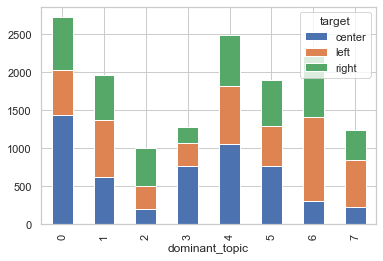

In [168]:
data.groupby(by=['dominant_topic','target']).count()['source'].unstack().plot(kind='bar',stacked=True)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/topic_by_target.png')

# EDA

In [169]:
%%time
vectorizer = TfidfVectorizer(max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 1), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)
vectorizer.fit(data.predictor)

CPU times: user 1min 3s, sys: 301 ms, total: 1min 3s
Wall time: 1min 4s


TfidfVectorizer(preprocessor=<function clean_txt at 0x141ca8ca0>, smooth_idf=1,
                strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [170]:
def create_tf_matrix(target):
    return vectorizer.transform(data[data.target == target].predictor)

def create_term_freq(matrix, cat):
    category_words = matrix.sum(axis=0)
    category_words_freq = [(word, category_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    return pd.DataFrame(list(sorted(category_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms', cat])

for cat in ['left','center','right']:
    print("Top 20 terms for: ", cat)
    df_right = create_term_freq(create_tf_matrix(cat), cat).head(20)
    print(df_right)
    print("###############")
    if cat != 'left':
        df_top20_words = df_top20_words.merge(df_right, how='outer')
    else:
        df_top20_words = df_right.copy()
    
    print(df_top20_words.shape )

Top 20 terms for:  left
          Terms        left
0         trump  164.324298
1   coronavirus  146.846630
2        people  125.556379
3         state  123.144096
4          test  121.951703
5         covid  121.763523
6     president  120.960108
7        health  112.918482
8          case  111.925305
9         virus  103.796882
10     pandemic  102.922844
11        house  102.481807
12         also   99.895443
13        would   99.023819
14        white   89.816696
15         mask   89.307592
16         time   89.215377
17         take   89.022498
18         tell   88.291918
19         week   88.244009
###############
(20, 2)
Top 20 terms for:  center
          Terms      center
0      stimulus  291.022357
1         check  273.488432
2      congress  270.808139
3          deal  262.732206
4        likely  252.789919
5   coronavirus  235.376312
6          send  234.251774
7          make  203.285292
8          case  142.737865
9         covid  115.426403
10       report  110.038025
11

In [171]:
df_top20_words.fillna(0, inplace=True )
df_top20_words.set_index('Terms', inplace=True)
df_top20_words.shape

(36, 3)

In [172]:
import numpy as np
from textacy.viz.termite import draw_termite_plot

In [173]:
df = df_top20_words.copy()
df_norm = (df) / (df.max() - df.min())

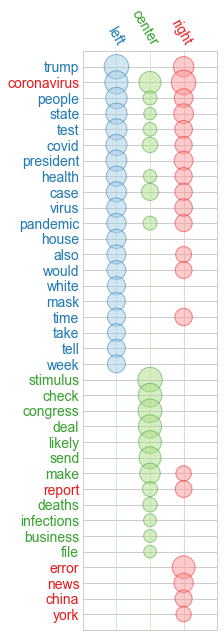

In [174]:
draw_termite_plot(np.array(df_norm.values),df_top20_words.columns,df_top20_words.index,highlight_cols=[0,1,2])
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/termite_plot.png')

**Polarity by target**

In [175]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

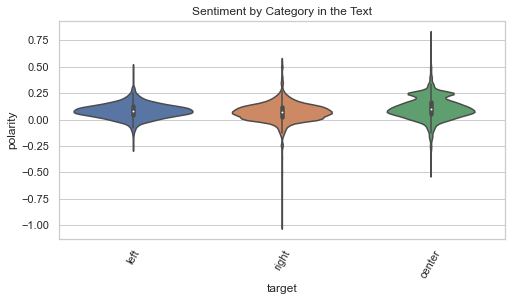

In [176]:
plt.figure(figsize=(8,4))
ax = sns.violinplot(x="target", y="polarity", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="polarity", data=data, color=".25")
ax.set_title('Sentiment by Category in the Text')
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/pol_by_target.png')

**Polarity over time**

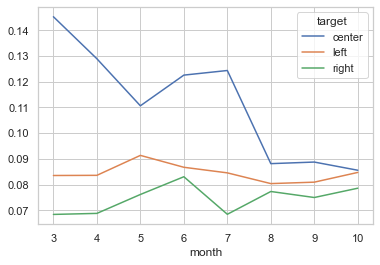

In [177]:
data.groupby(by=['month','target'])['polarity'].mean().unstack().plot()
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/pol_time.png')

**Subjectivity by target**

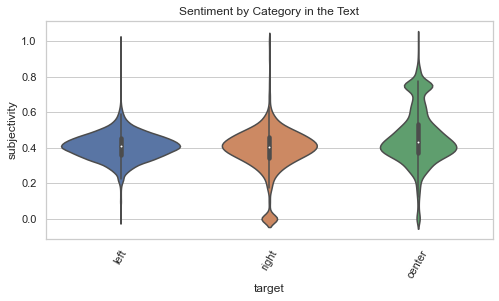

In [178]:
plt.figure(figsize=(8,4))
ax = sns.violinplot(x="target", y="subjectivity", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="polarity", data=data, color=".25")
ax.set_title('Sentiment by Category in the Text')
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/sub_by_target.png')

**Subjectivity over time**

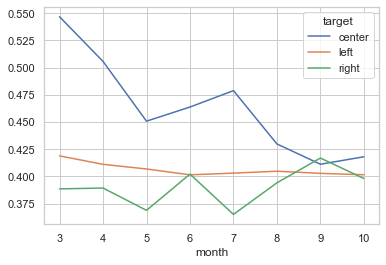

In [179]:
data.groupby(by=['month','target'])['subjectivity'].mean().unstack().plot()
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/sub_time.png')

**n_long_words by target**

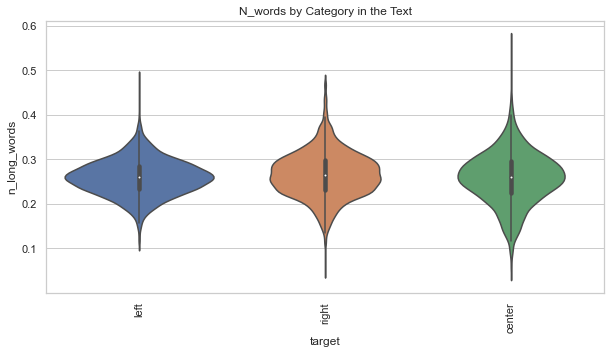

In [180]:
plt.figure(figsize=(10,5))
ax = sns.violinplot(x="target", y="n_long_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N_words by Category in the Text')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/longwords_target.png')

**n_monosyllable_words by target**

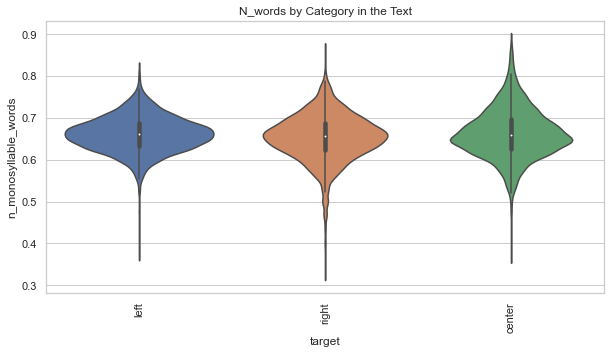

In [181]:
plt.figure(figsize=(10,5))
ax = sns.violinplot(x="target", y="n_monosyllable_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N_words by Category in the Text')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/mono_target.png')

**n_polysyllable_words by target**

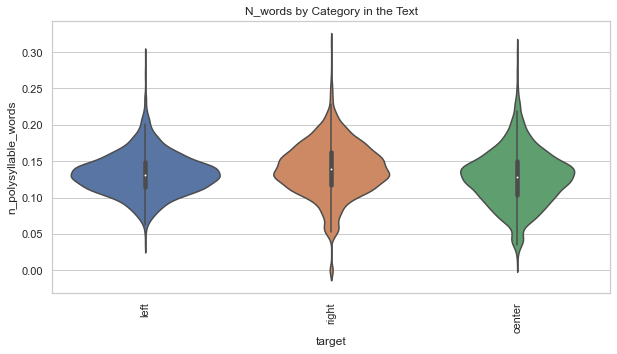

In [182]:
plt.figure(figsize=(10,5))
ax = sns.violinplot(x="target", y="n_polysyllable_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N_words by Category in the Text')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/poly_target.png')

**n_unique_words by target**

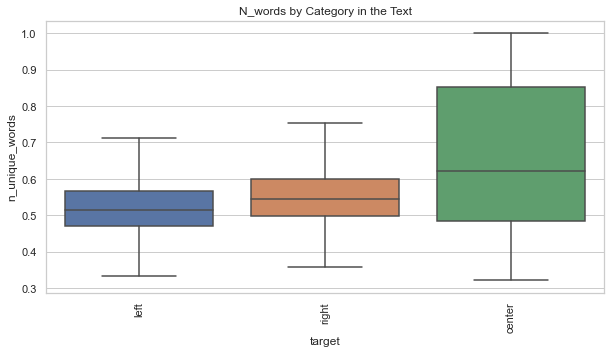

In [183]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="target", y="n_unique_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N_words by Category in the Text')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/unique_target.png')